In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using Distributions
using PyPlot
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using Distributed
using LAR
using LAR.Node

include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/auxiliary/buffer.jl")
include("../functions/preprocessing.jl")
include("ARFB_fast_cossin.jl")

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
# signal statistics 
N = 5000
fs = 4

# process parameters
ρ1 = 0.999
ρ2 = 0.7
f1 = 0.3
f2 = 1.5
σ_p1 = 0.2
σ_p2 = 0.3
σ_n = 0.01

# create signal (option 1)
si1 = Array{Float64,1}(undef, N)
si2 = Array{Float64,1}(undef, N)
si3 = Array{Float64,1}(undef, N)
si4 = Array{Float64,1}(undef, N)
xi = Array{Float64,1}(undef, N)
yi = Array{Float64,1}(undef, N)
si1[1] = 0 
si2[1] = 0 
si3[1] = 0 
si4[1] = 0 
xi[1] = 0
yi[1] = 0
for n = 2:N
    si1[n] = ρ1*si1[n-1] + rand(Normal(0, σ_p1)) 
    si2[n] = ρ2*si2[n-1] + rand(Normal(0, σ_p2)) 
    si3[n] = ρ1*si3[n-1] + rand(Normal(0, σ_p1)) 
    si4[n] = ρ2*si4[n-1] + rand(Normal(0, σ_p2)) 
    xi[n] = si1[n]*cos(2*pi*f1/fs*n) + si2[n]*cos(2*pi*f2/fs*n) + si3[n]*sin(2*pi*f1/fs*n) + si4[n]*sin(2*pi*f2/fs*n)
    yi[n] = rand(Normal(xi[n], σ_n))
end

t = collect(1:N)/fs
;

In [12]:
#f = collect(0.2:0.1:2)
f = [0.3, 1.5]
bufsize = length(f)*2

# create fg
fg = FactorGraph()

@RV [id=:θ1] θ1 ~ GaussianMeanVariance(placeholder(:μ_θ1), placeholder(:Σ_θ1))
@RV [id=:γ1] γ1 ~ ForneyLab.Gamma(placeholder(:a_γ1), placeholder(:b_γ1))
@RV [id=:smin1] smin1 ~ GaussianMeanVariance(placeholder(:μ_smin1), placeholder(:Σ_smin1))
@RV [id=:s1] s1 ~ Autoregressive(θ1, smin1, γ1)

@RV [id=:θ2] θ2 ~ GaussianMeanVariance(placeholder(:μ_θ2), placeholder(:Σ_θ2))
@RV [id=:γ2] γ2 ~ ForneyLab.Gamma(placeholder(:a_γ2), placeholder(:b_γ2))
@RV [id=:smin2] smin2 ~ GaussianMeanVariance(placeholder(:μ_smin2), placeholder(:Σ_smin2))
@RV [id=:s2] s2 ~ Autoregressive(θ2, smin2, γ2)

@RV [id=:smin3] smin3 ~ GaussianMeanVariance(placeholder(:μ_smin3), placeholder(:Σ_smin3))
@RV [id=:s3] s3 ~ Autoregressive(θ1, smin3, γ1)

@RV [id=:smin4] smin4 ~ GaussianMeanVariance(placeholder(:μ_smin4), placeholder(:Σ_smin4))
@RV [id=:s4] s4 ~ Autoregressive(θ2, smin4, γ2)

@RV s

DotProduct(s1, [1, 0, 0, 0], s)
DotProduct(s2, [0, 0, 1, 0], s)
DotProduct(s3, [0, 1, 0, 0], s)
DotProduct(s4, [0, 0, 0, 1], s)

@RV [id=:x] x = placeholder(:c, dims=(bufsize,2*length(f))) * s
@RV [id=:y] y ~ GaussianMeanVariance(x, placeholder(:Σ_x, dims=(bufsize,bufsize)))
placeholder(y, :y, dims=(bufsize,))

q = PosteriorFactorization(smin1, s1, θ1, γ1, smin2, s2, θ2, γ2, smin3, smin4, s3, s4, ids=[:smin1, :s1, :θ1, :γ1, :smin2, :s2, :θ2, :γ2, :smin3, :smin4, :s3, :s4])

ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 8130624057115088112 -->
 8130624057115088112 
 
 placeholder_b_γ2 
 
<!-- 16896871091469552181 -->
 16896871091469552181 
 
 placeholder_y 
 
<!-- 3610315514554388982 -->
 3610315514554388982 
 
 𝒩 
 gaussianmeanvariance_7 
 
<!-- 16896871091469552181--3610315514554388982 -->
 16896871091469552181--3610315514554388982 
 
 y 
 1 out 
 1 out 
 
<!-- 10218716797378027017 -->
 10218716797378027017 
 
 placeholder_Σ_smin2 
 
<!-- 17941498954112511076 -->
 17941498954112511076 
 
 dot 
 dotproduct_3 
 
<!-- 1669470271264090940 -->
 1669470271264090940 
 
 clamp_3 
 
<!-- 17941498954112511076--1669470271264090940 -->
 17941498954112511076--1669470271264090940 
 
 clamp_3 
 1 out 
 2 in1 
 
<!-- 5244236942195213373 -->
 5244236942195213373 
 
 AR 
 autoregressive_3 
 
<!-- 17941498954112511076--5244236942195213373 -->
 17941498954112511076--5244236942195213373 
 
 s3 
 1 y 
 1 out 
 
<!-- 12538161410765067037 -->
 12538161410765067037 
 
 placeholder_Σ_θ2 
 
<!-- 18083259117158642516 -->
 18083259117158642516 
 
 placeholder_Σ_smin1 
 
<!-- 17573742922535088649 -->
 17573742922535088649 
 
 = 
 equ_θ1_1 
 
<!-- 16469499303289862892 -->
 16469499303289862892 
 
 AR 
 autoregressive_1 
 
<!-- 17573742922535088649--16469499303289862892 -->
 17573742922535088649--16469499303289862892 
 
 θ1 
 3 θ 
 2 2 
 
<!-- 18100801178837544647 -->
 18100801178837544647 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 17573742922535088649--18100801178837544647 -->
 17573742922535088649--18100801178837544647 
 
 θ1 
 1 out 
 1 1 
 
<!-- 17573742922535088649--5244236942195213373 -->
 17573742922535088649--5244236942195213373 
 
 θ1 
 3 θ 
 3 3 
 
<!-- 6819333200615236600 -->
 6819333200615236600 
 
 placeholder_Σ_θ1 
 
<!-- 5389158718754336130 -->
 5389158718754336130 
 
 AR 
 autoregressive_2 
 
<!-- 14353045175962149883 -->
 14353045175962149883 
 
 𝒩 
 gaussianmeanvariance_4 
 
<!-- 5389158718754336130--14353045175962149883 -->
 5389158718754336130--14353045175962149883 
 
 smin2 
 1 out 
 2 x 
 
<!-- 6367265964570643661 -->
 6367265964570643661 
 
 dot 
 dotproduct_4 
 
<!-- 10255969095287544282 -->
 10255969095287544282 
 
 clamp_4 
 
<!-- 6367265964570643661--10255969095287544282 -->
 6367265964570643661--10255969095287544282 
 
 clamp_4 
 1 out 
 2 in1 
 
<!-- 6877014862708672565 -->
 6877014862708672565 
 
 AR 
 autoregressive_4 
 
<!-- 6367265964570643661--6877014862708672565 -->
 6367265964570643661--6877014862708672565 
 
 s4 
 1 y 
 1 out 
 
<!-- 5712397128672694760 -->
 5712397128672694760 
 
 = 
 equ_s_3 
 
<!-- 5712397128672694760--6367265964570643661 -->
 5712397128672694760--6367265964570643661 
 
 s 
 3 in2 
 1 1 
 
<!-- 13265503784741854055 -->
 13265503784741854055 
 
 × 
 multiplication_1 
 
<!-- 5712397128672694760--13265503784741854055 -->
 5712397128672694760--13265503784741854055 
 
 s 
 2 in1 
 3 3 
 
<!-- 6120802062198615543 -->
 6120802062198615543 
 
 = 
 equ_s_2 
 
<!-- 5712397128672694760--6120802062198615543 -->
 5712397128672694760--6120802062198615543 
 
 s 
 3 3 
 2 2 
 
<!-- 13410843457324017898 -->
 13410843457324017898 
 
 dot 
 dotproduct_1 
 
<!-- 13410843457324017898--16469499303289862892 -->
 13410843457324017898--16469499303289862892 
 
 s1 
 1 y 
 1 out 
 
<!-- 3597370051402178605 -->
 3597370051402178605 
 
 clamp_1 
 
<!-- 13410843457324017898--3597370051402178605 -->
 13410843457324017898--3597370051402178605 
 
 clamp_1 
 1 out 
 2 in1 
 
<!-- 8873101397569678666 -->
 8873101397569678666 
 
 placeholder_μ_smin4 
 
<!-- 42921

In [13]:
# generate algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))
println(source_code)

begin

function steps1!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 24))

messages[1] = ruleVariationalAROutNPPP(nothing, marginals[:smin4], marginals[:θ2], marginals[:γ2])
messages[2] = ruleSPDotProductIn2GPN(messages[1], Message(ForneyLab.Multivariate, PointMass, m=[0, 0, 0, 1]), nothing)
messages[3] = ruleVariationalAROutNPPP(nothing, marginals[:smin3], marginals[:θ1], marginals[:γ1])
messages[4] = ruleSPDotProductIn2GPN(messages[3], Message(ForneyLab.Multivariate, PointMass, m=[0, 1, 0, 0]), nothing)
messages[5] = ruleVariationalAROutNPPP(nothing, marginals[:smin1], marginals[:θ1], marginals[:γ1])
messages[6] = ruleSPDotProductIn2GPN(messages[5], Message(ForneyLab.Multivariate, PointMass, m=[1, 0, 0, 0]), nothing)
messages[7] = ruleVariationalAROutNPPP(nothing, marginals[:smin2], marginals[:θ2], marginals[:γ2])
messages[8] = ruleSPDotProductIn2GPN(messages[7], Message(ForneyLab.Multivariate, PointMass, m=[0, 0, 1, 0]), nothing)
messages[9] = 

In [14]:
μ_θ_mem = Array{Float64,2}(undef, N, length(f))
Σ_θ_mem = Array{Float64,2}(undef, N, length(f))
m_γ_mem = Array{Float64,2}(undef, N, length(f))
μ_x_mem = Array{Float64,1}(undef, N)
Σ_x_mem = Array{Float64,1}(undef, N)

# priors
μ_smin = zeros(2*length(f))
Σ_smin = 0.1*Ic(2*length(f))
μ_θ = 0.0*ones(length(f))
Σ_θ = 0.5*Ic(length(f))
a_γ = 1.0*ones(length(f))
b_γ = 0.001*ones(length(f))
Σ_x = 0.01*0.01*Ic(bufsize)

p = Progress(N-bufsize)

for n = bufsize:N
    
    next!(p)
    
    # fill marginals dictionary
    marginals = Dict()
    marginals[:smin1] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanVariance, m=μ_smin[1], v=Σ_smin[1,1])
    marginals[:θ1] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanVariance, m=μ_θ[1], v=Σ_θ[1,1])
    marginals[:γ1] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_γ[1], b=b_γ[1])
    marginals[:smin2] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanVariance, m=μ_smin[2], v=Σ_smin[2,2])
    marginals[:θ2] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanVariance, m=μ_θ[2], v=Σ_θ[2,2])
    marginals[:γ2] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=a_γ[2], b=b_γ[2])
    marginals[:smin3] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanVariance, m=μ_smin[3], v=Σ_smin[3,3])
    marginals[:smin4] = ProbabilityDistribution(ForneyLab.Univariate, GaussianMeanVariance, m=μ_smin[4], v=Σ_smin[4,4])

    # fill data dictionary
    data = Dict()
    data[:μ_smin1] = μ_smin[1]
    data[:Σ_smin1] = Σ_smin[1,1]
    data[:μ_θ1] = μ_θ[1]
    data[:Σ_θ1] = Σ_θ[1,1]
    data[:a_γ1] = a_γ[1]
    data[:b_γ1] = b_γ[1]
    data[:μ_smin2] = μ_smin[2]
    data[:Σ_smin2] = Σ_smin[2,2]
    data[:μ_θ2] = μ_θ[2]
    data[:Σ_θ2] = Σ_θ[2,2]
    data[:a_γ2] = a_γ[2]
    data[:b_γ2] = b_γ[2]
    data[:μ_smin3] = μ_smin[3]
    data[:Σ_smin3] = Σ_smin[3,3]
    data[:μ_smin4] = μ_smin[4]
    data[:Σ_smin4] = Σ_smin[4,4]
    data[:c] = reshape( [cos.(2*pi*f*t[n-bufsize+1:n]') sin.(2*pi*f*t[n-bufsize+1:n]')]', bufsize, 2*length(f))
    data[:Σ_x] = Σ_x*Ic(bufsize)
    data[:y] = yi[n-bufsize+1:n]   
    
    # make prediction
    messages = Array{Message}(undef, 24)
    Base.invokelatest(steps1!, data, marginals, messages)
    μ_x_mem[n] = ForneyLab.unsafeMean(messages[12].dist)[end]
    Σ_x_mem[n] = ForneyLab.unsafeCov(messages[12].dist)[end,end]
    
    # perform updates
    for _ in 1:5
        Base.invokelatest(steps1!, data, marginals)
        Base.invokelatest(steps2!, data, marginals)
        Base.invokelatest(steps3!, data, marginals)
        Base.invokelatest(steps4!, data, marginals)
        Base.invokelatest(stepθ1!, data, marginals)
        Base.invokelatest(stepθ2!, data, marginals)
        Base.invokelatest(stepγ1!, data, marginals)
        Base.invokelatest(stepγ2!, data, marginals)
        Base.invokelatest(stepsmin1!, data, marginals)
        Base.invokelatest(stepsmin2!, data, marginals)
        Base.invokelatest(stepsmin3!, data, marginals)
        Base.invokelatest(stepsmin4!, data, marginals)
    end
    
    # update parameters
    μ_smin[1] = ForneyLab.unsafeMean(marginals[:s1])
    Σ_smin[1,1] = ForneyLab.unsafeCov(marginals[:s1])
    μ_θ[1] = ForneyLab.unsafeMean(marginals[:θ1])
    Σ_θ[1,1] = ForneyLab.unsafeCov(marginals[:θ1])
    a_γ[1] = marginals[:γ1].params[:a]
    b_γ[1] = marginals[:γ1].params[:b]
    μ_smin[2] = ForneyLab.unsafeMean(marginals[:s2])
    Σ_smin[2,2] = ForneyLab.unsafeCov(marginals[:s2])
    μ_θ[2] = ForneyLab.unsafeMean(marginals[:θ2])
    Σ_θ[2,2] = ForneyLab.unsafeCov(marginals[:θ2])
    a_γ[2] = marginals[:γ2].params[:a]
    b_γ[2] = marginals[:γ2].params[:b]
    μ_smin[3] = ForneyLab.unsafeMean(marginals[:s3])
    Σ_smin[3,3] = ForneyLab.unsafeCov(marginals[:s3])
    μ_smin[4] = ForneyLab.unsafeMean(marginals[:s4])
    Σ_smin[4,4] = ForneyLab.unsafeCov(marginals[:s4])

    # save parameters
    μ_θ_mem[n,:] = μ_θ
    Σ_θ_mem[n,:] = diag(Σ_θ)
    m_γ_mem[n,:] = a_γ ./ b_γ
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


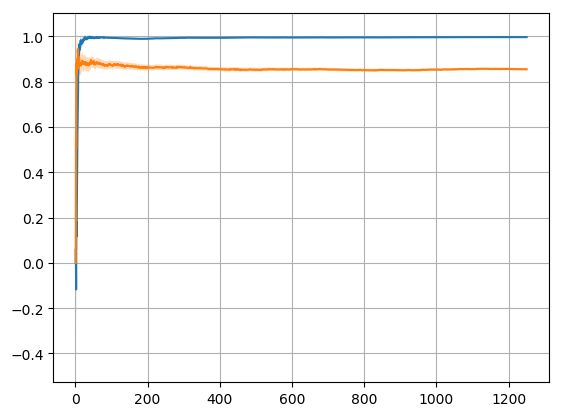

In [15]:
for k = 1:size(μ_θ_mem,2)
    plt.plot(t[bufsize:end], μ_θ_mem[bufsize:end,k])
    plt.fill_between(t[bufsize:end], μ_θ_mem[bufsize:end,k].+sqrt.(Σ_θ_mem[bufsize:end,k]), μ_θ_mem[bufsize:end,k].-sqrt.(Σ_θ_mem[bufsize:end,k]), alpha=0.3)
end
plt.grid()

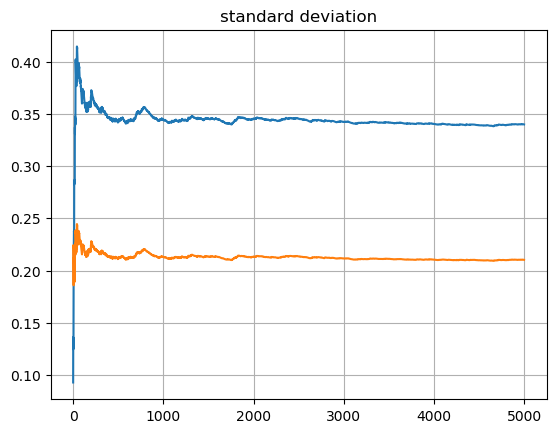

(nothing, PyObject Text(0.5, 1.0, 'standard deviation'))

In [16]:
plt.plot(1 ./ sqrt.(m_γ_mem[bufsize:end,:]))
plt.grid(), plt.title("standard deviation")

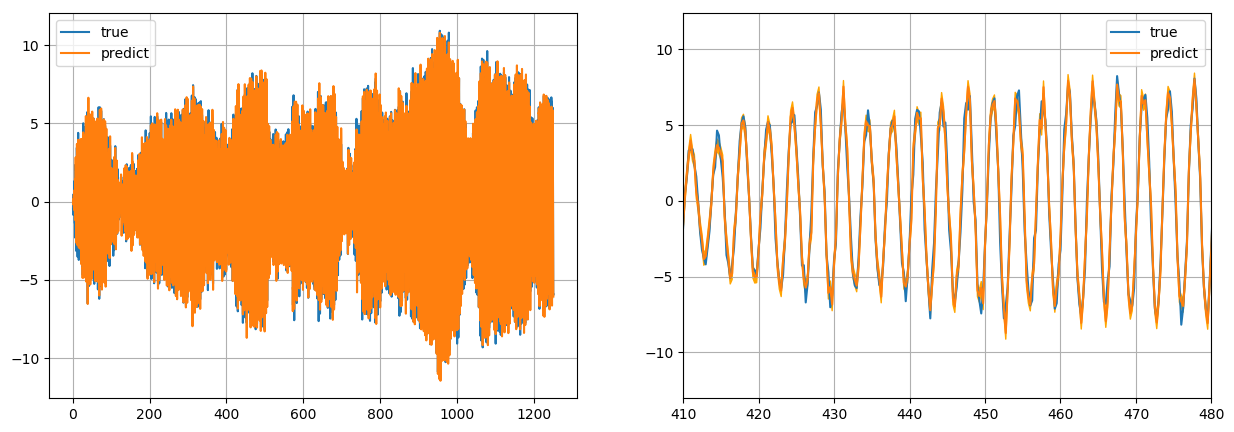

(nothing, PyObject <matplotlib.legend.Legend object at 0x000000000141F128>, (410, 480))

In [17]:
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(t[bufsize:end], xi[bufsize:end], label="true")
ax[1].plot(t[bufsize:end], μ_x_mem[bufsize:end], label="predict")
ax[1].grid(), ax[1].legend()
ax[2].plot(t[bufsize:end], xi[bufsize:end], label="true")
ax[2].plot(t[bufsize:end], μ_x_mem[bufsize:end], label="predict")
ax[2].fill_between(t[bufsize:end], μ_x_mem[bufsize:end] .+ sqrt.(Σ_x_mem[bufsize:end]), μ_x_mem[bufsize:end] .- sqrt.(Σ_x_mem[bufsize:end]), color="orange")
ax[2].grid(), ax[2].legend(), ax[2].set_xlim(410,480)

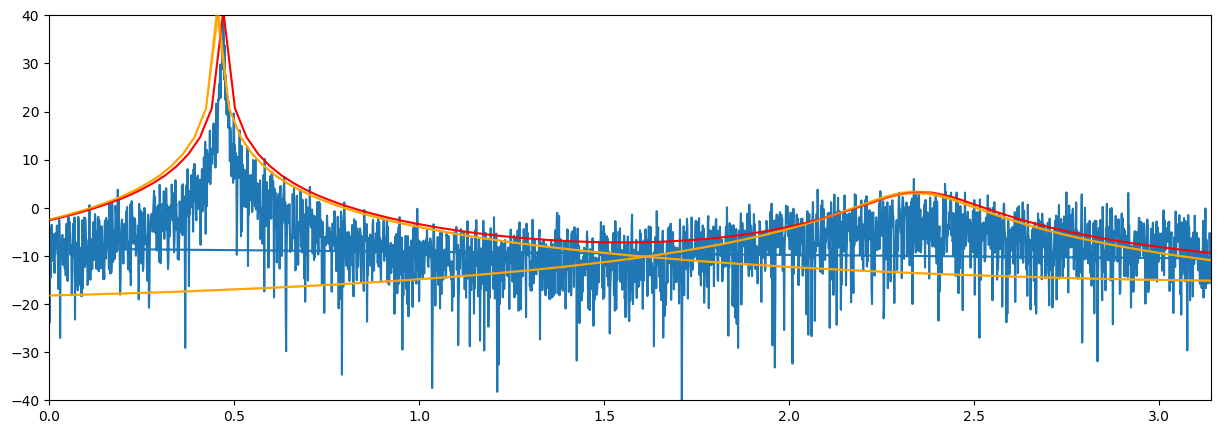

(0, 3.141592653589793)

In [18]:
plt.figure(figsize=(15,5))

plt.plot(FFTW.fftfreq(length(yi), fs)/fs*2*pi, 10*log10.((abs.(FFTW.fft(yi)).^2)./length(yi)))

tmp_psd = zeros(101)
for k = 1:length(f)
    θ_sampled, γ_sampled = AR_distributions([μ_θ_mem[end,k]], mat(1/Σ_θ_mem[end,k]), a_γ[k], b_γ[k])
    mean_psd, std_psd = summary_psd(θ_sampled, γ_sampled)
    mean_psd = vcat(reverse(mean_psd), mean_psd[2:end])
    std_psd = vcat(reverse(std_psd), std_psd[2:end])
    θx = collect(0:length(mean_psd)-1)/length(mean_psd)*2*pi .- pi .+ 2*pi*f[k]/fs
    gca().plot(θx, mean_psd, color="orange", label="predicted psd")
    gca().fill_between(θx, mean_psd .- std_psd, mean_psd .+ std_psd, color="orange", alpha=0.5, zorder=100)
    tmp_psd = tmp_psd + 10 .^(mean_psd[101-Int(round(f[k]/fs*200)):201-Int(round(f[k]/fs*200))]/10)
end
gca().plot(collect(0:100)/100*pi, 10*log10.(tmp_psd), color="red")
plt.ylim(-40, 40)

plt.xlim(0,pi)

## Predictive performance

In [19]:
x_true = xi[bufsize:end]
x_μ_pred = μ_x_mem[bufsize:end]
x_σ_pred = sqrt.(abs.(Σ_x_mem[bufsize:end]));

In [20]:
MSE = mean(abs2.(x_true - x_μ_pred))
MAE = mean(abs.(x_true - x_μ_pred))
BME = mean([logpdf(Normal(x_μ_pred[k], x_σ_pred[k]), x_true[k]) for k = 1:length(x_true)])

MSE, MAE, BME

(0.458937442843667, 0.5368496410585115, -1.4282466226230919)